In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions

In [122]:
# Global variables, hyperparameters (alpha = inverse aplha)
N_data = 30
alpha = 1
beta = 0.01

In [107]:
# Toy data
X = tf.transpose(tf.constant([[0.02, 0.12, 0.145, 0.1654, 0.143,
                               0.1123, 0.21, 0.145, 0.167, 0.1456,
                               0.186, 0.145, 0.134, 0.81, 0.82, 0.832,
                               0.811, 0.842, 0.8234, 0.885, 0.9, 0.91,
                               0.93, 0.933, 0.03, 0.98, 0.81234, 0.79,
                               0.099, 0.0988]]))
Y = 0.5 * tf.math.sin(3*X) + tf.random.normal((N_data, 1), 0, 0.01)

In [108]:
# Model architecture
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='tanh', name='dense_2', input_shape = (1,)),
        tf.keras.layers.Dense(64, activation='tanh', name='dense_3'),
        tf.keras.layers.Dense(1, activation='linear', name='dense_6')
        ])

In [109]:
def adjust_shapes(weights, weights_shapes):
    adjusted_weights = []
    for shape_ in weights_shapes:
        shape_size = np.prod(shape_)
        weights_tmp = weights[:shape_size]
        weights = weights[shape_size:]
        adjusted_weights.append(np.reshape(weights_tmp, shape_))
    return adjusted_weights

In [110]:
def log_join_probability(X, Y, weights):
    k = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    weights_shapes = [v.get_shape() for v in model.trainable_weights]
    prior = tfd.MultivariateNormalDiag(scale_diag = alpha * tf.ones(k))
    model.set_weights(adjust_shapes(tf.reshape(weights, (k,)), weights_shapes))
    likelihood = tfd.Normal(model.predict(X), scale = beta)
    return prior.log_prob(weights) + sum(likelihood.log_prob(Y))

In [152]:
unnormalized_posterior_log_prob = lambda *args: log_join_probability(X, Y, *args)
k = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])

hmc = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn = unnormalized_posterior_log_prob,
    step_size = 0.1 * tf.ones(shape = (1,k)),
    max_tree_depth=15, max_energy_diff=2000.0,
    unrolled_leapfrog_steps=5, parallel_iterations=10, seed=123, name=None
)


In [153]:
samples = tfp.mcmc.sample_chain(
    num_results = int(20000),
    num_burnin_steps = int(2000),
    current_state = tf.random.normal(stddev = 0.15, shape = (1,k)),
    kernel = hmc,
    trace_fn = None)

x_plot = np.arange(-0.3, 1.3, 0.01)
x_plot = [x for x in x_plot]

preds = []
for i in range(20000):
    model.set_weights(adjust_shapes(tf.reshape(samples[i], (k,)), weights_shapes))
    preds.append(model.predict(x_plot))

mmean = []
ssd = []
for i in range(160):
    mmean.append(np.mean(np.transpose(preds)[0][i]))
    ssd.append(np.std(np.transpose(preds)[0][i]))

In [156]:
preds =[]
for i in range(20000):
    model.set_weights(adjust_shapes(tf.reshape(samples[i], (k,)), weights_shapes))
    preds.append(model.predict(x_plot))

mmean = []
ssd = []
for i in range(160):
    mmean.append(np.mean(np.transpose(preds)[0][i]))
    ssd.append(np.std(np.transpose(preds)[0][i]))

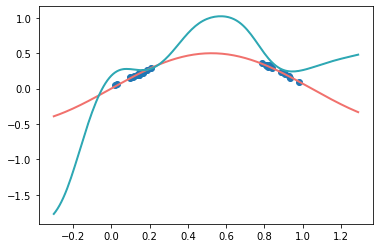

In [157]:
fig, ax = plt.subplots()
ax.plot(x_plot, [0.5 * np.sin(3 * i) for i in x_plot], color = '#f1716d', linewidth = 2.0, label = 'original')
ax.scatter(X,Y)
ax.plot(x_plot, mmean, color = "#2ea8b4", linewidth = 2.0, label = 'prediction')
ax.plot(x_plot, np.subtract(mmean, ssd),
         color = '#2ea8b4', linestyle = 'dashed', linewidth = 0.5, label = 'uncertainty')
ax.plot(x_plot,  np.add(mmean, ssd),
         color = '#2ea8b4', linestyle = 'dashed', linewidth = 0.5)


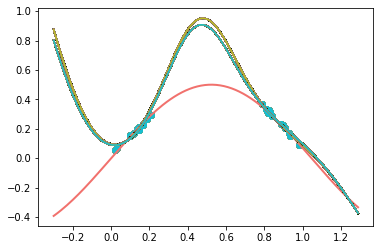

In [116]:
x_plot = np.arange(-0.3, 1.3, 0.01)
x_plot = [x for x in x_plot]

fig, ax = plt.subplots()
ax.plot(x_plot, [0.5 * np.sin(3 * i) for i in x_plot], color = '#f1716d', linewidth = 2.0, label = 'original')

for i in range(2000):
    if i % 100:
        model.set_weights(adjust_shapes(tf.reshape(samples[i], (k,)), weights_shapes))
        ax.plot(x_plot, model.predict(x_plot))
        ax.scatter(X,Y)

In [99]:
samples[0] == samples[4]

<tf.Tensor: shape=(1, 8577), dtype=bool, numpy=array([[False, False, False, ..., False, False, False]])>

In [136]:
model.predict(X[[1]])

array([[1.1935934e+10]], dtype=float32)

In [31]:
weights_shape = [v.shape for v in model.trainable_weights]
weights_num = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
weights_num

10625